##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Pitch Detection with SPICE

This colab will show you how to use the SPICE model downloaded from TensorFlow Hub.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from scipy.io import wavfile

from base64 import b64decode

from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

tensorflow: 2.12.0


d:\Anaconda3\envs\MIR_Final\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Preparing the audio data

Now we have the audio, let's convert it to the expected format and then listen to it!

The SPICE model needs as input an audio file at a sampling rate of 16kHz and with only one channel (mono). 

To help you with this part, we created a function (`convert_audio_for_model`) to convert any wav file you have to the model's expected format:

In [2]:
uploaded_file_name = "C:/Users/user/Desktop/MIR-FINAL/music/output.wav"

In [2]:
# Function that converts the user-created audio to the format that the model 
# expects: bitrate 16kHz and only one channel (mono).
# EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  EXPECTED_SAMPLE_RATE = 16000
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [7]:
# Converting to the expected format for the model
# in all the input 4 input method before, the uploaded file name is at
# the variable uploaded_file_name
converted_audio_file = convert_audio_for_model(uploaded_file_name)

In [8]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
# Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 24.75s
Size of the input: 396040


First thing, let's take a look at the waveform of our singing.

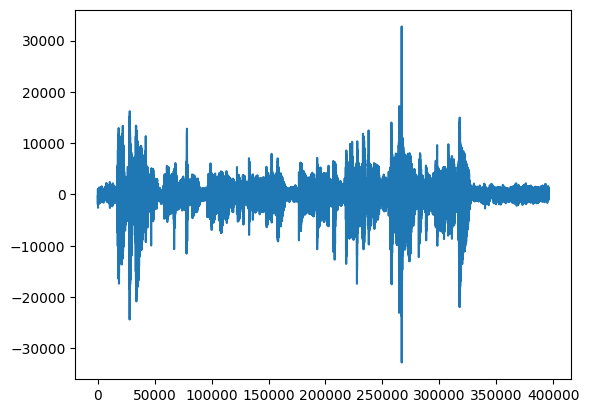

In [9]:
# We can visualize the audio as a waveform.
_ = plt.plot(audio_samples)

A more informative visualization is the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), which shows frequencies present over time.

Here, we use a logarithmic frequency scale, to make the singing more clearly visible.


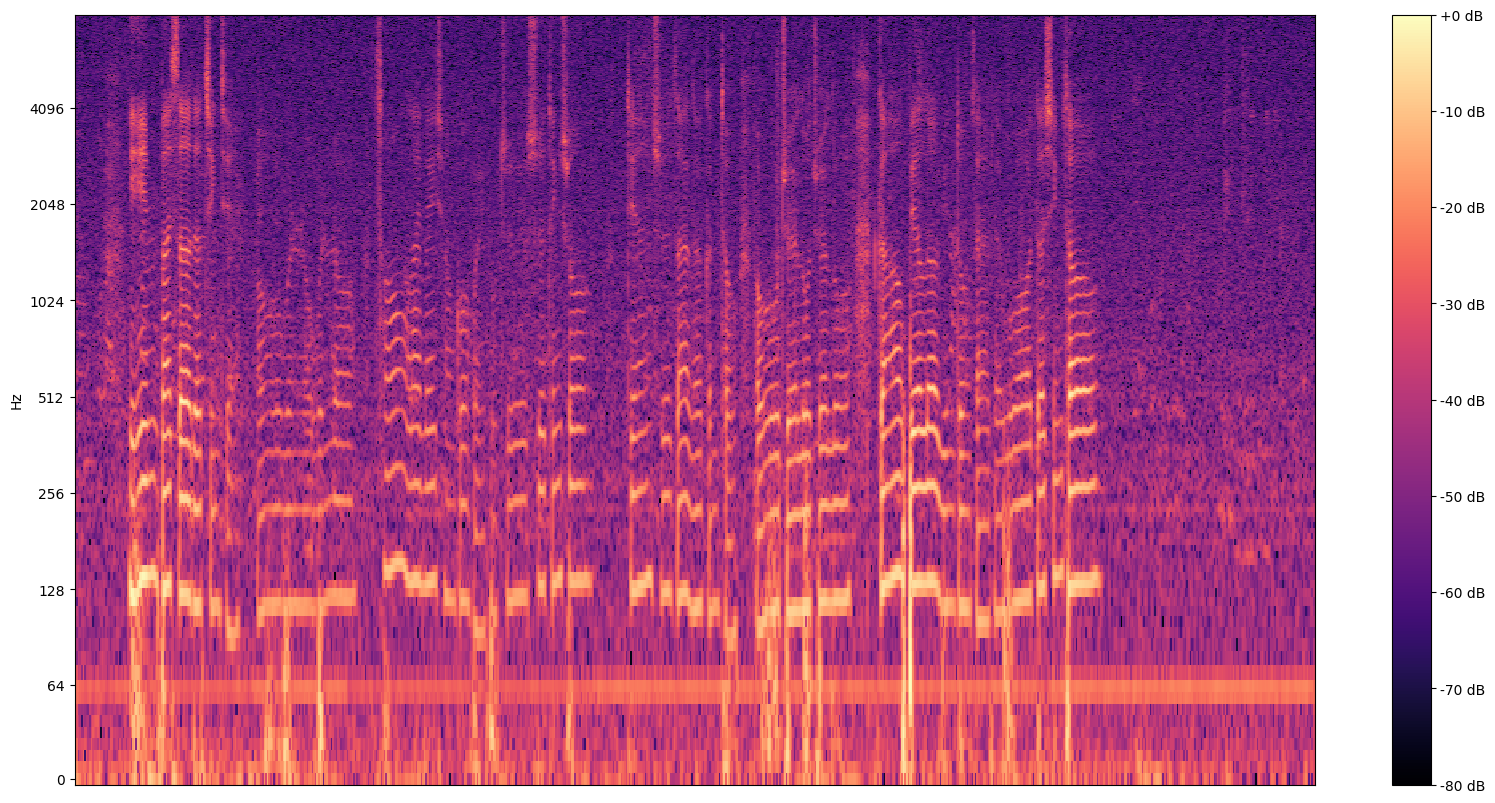

In [10]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log', 
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()


We need one last conversion here. The audio samples are in int16 format. They need to be normalized to floats between -1 and 1.

In [11]:
audio_samples = audio_samples / float(MAX_ABS_INT16)

# Executing the Model
Now is the easy part, let's load the model with **TensorFlow Hub**, and feed the audio to it.
SPICE will give us two outputs: pitch and uncertainty




**TensorFlow Hub** is a library for the publication, discovery, and consumption of reusable parts of machine learning models. It makes easy to use machine learning to solve your challenges.

To load the model you just need the Hub module and the URL pointing to the model:

In [12]:
# Loading the SPICE model is easy:
model = hub.load("https://tfhub.dev/google/spice/2")

**Note:** An interesting detail here is that all the model urls from Hub can be used for download and also to read the documentation, so if you point your browser to that link you can read documentation on how to use the model and learn more about how it was trained.

With the model loaded, data prepared, we need 3 lines to get the result: 

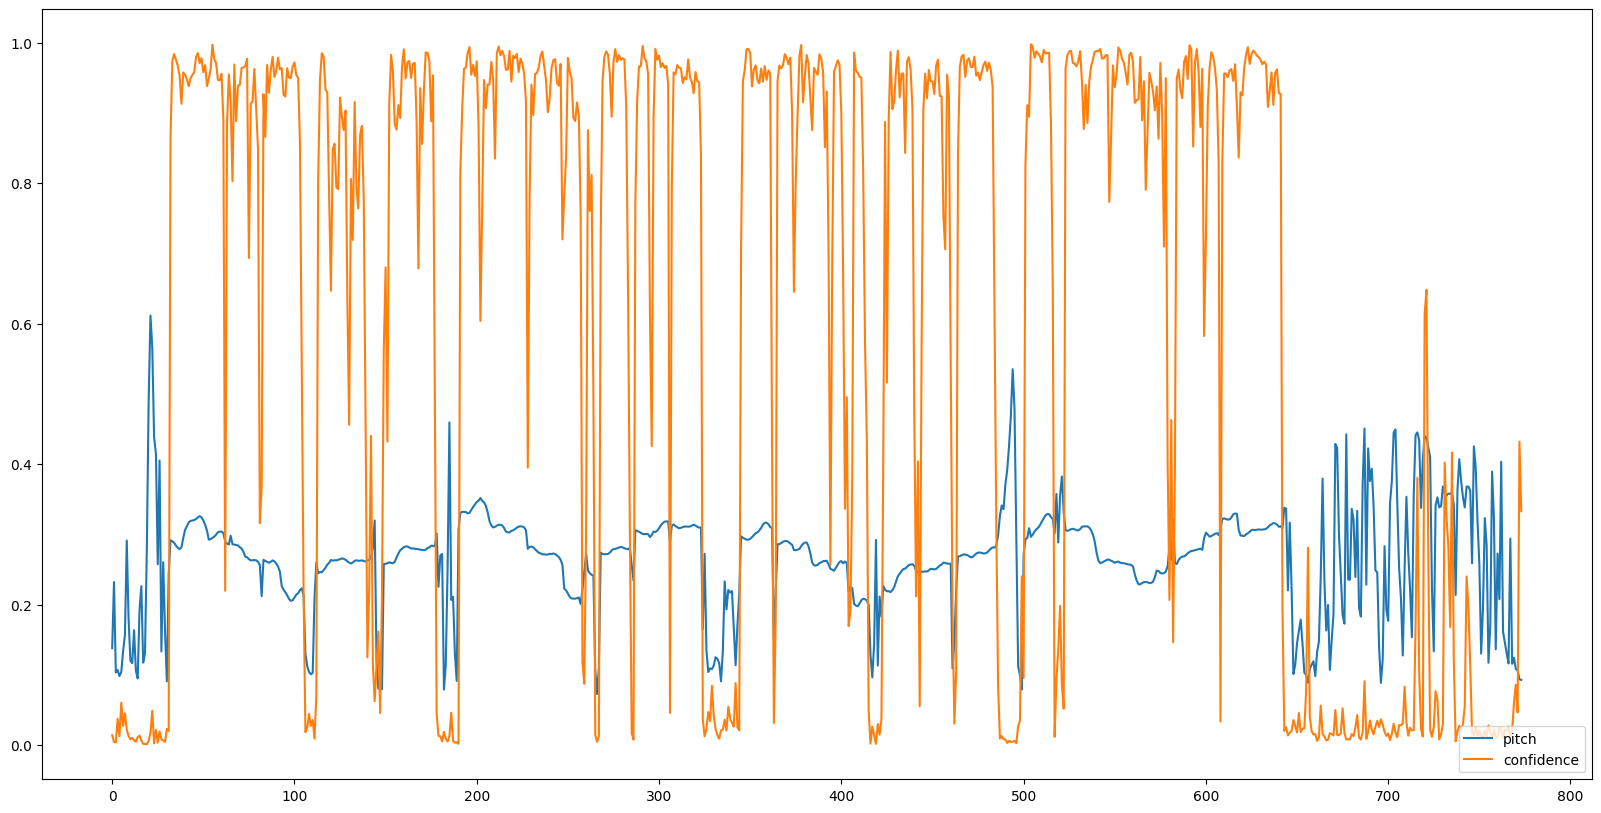

In [13]:
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

Let's make the results easier to understand by removing all pitch estimates with low confidence (confidence < 0.9) and plot the remaining ones.



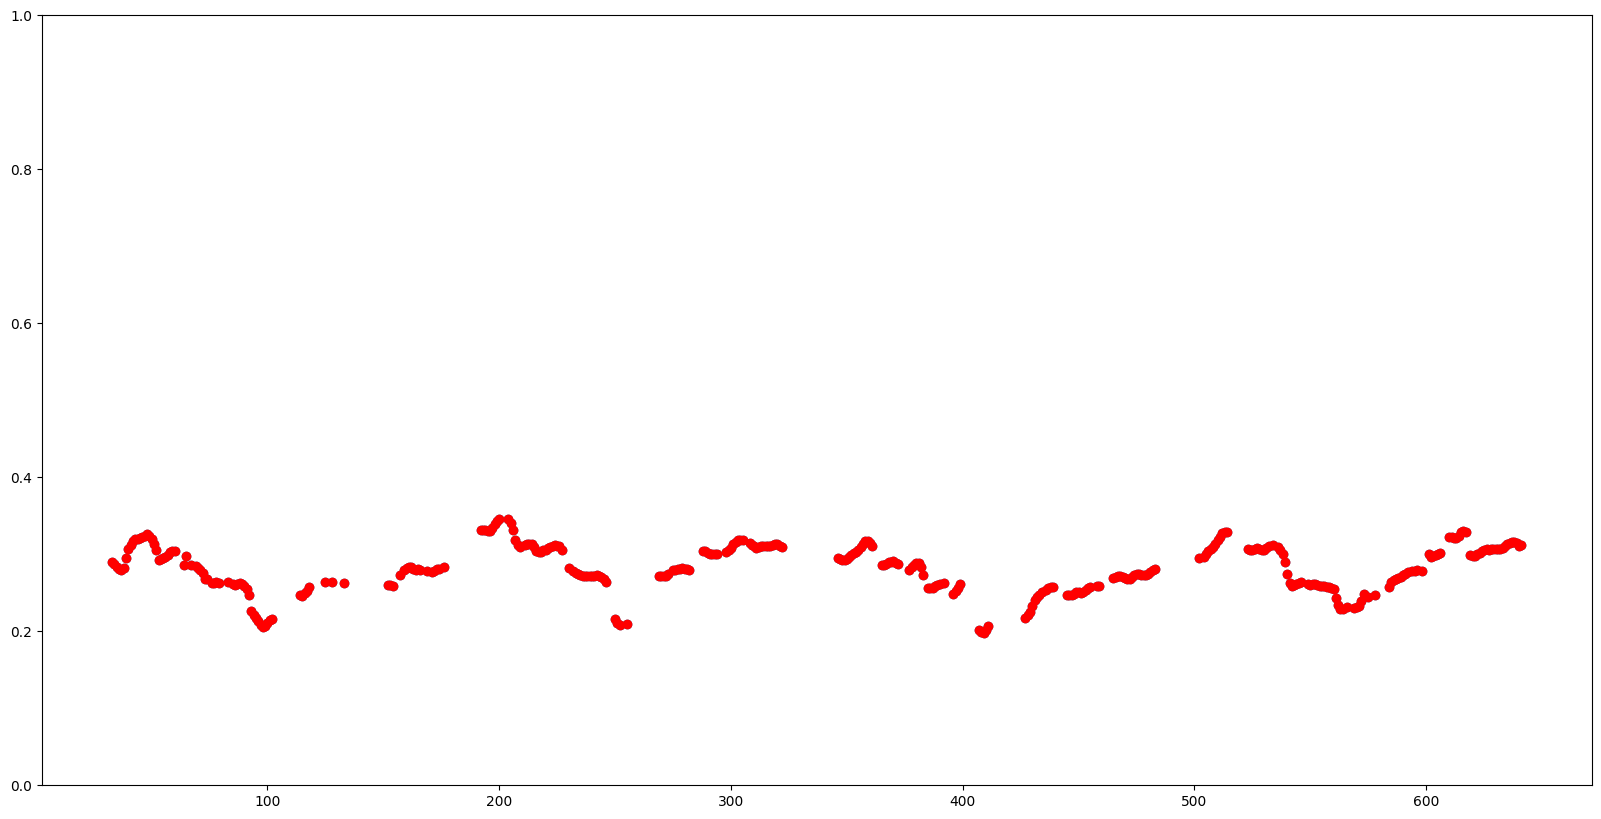

In [14]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
 
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

plt.show()

The pitch values returned by SPICE are in the range from 0 to 1. Let's convert them to absolute pitch values in Hz.

In [3]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)
    
# confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

Now, let's see how good the prediction is: We will overlay the predicted pitches over the original spectrogram. To make the pitch predictions more visible, we changed the spectrogram to black and white.

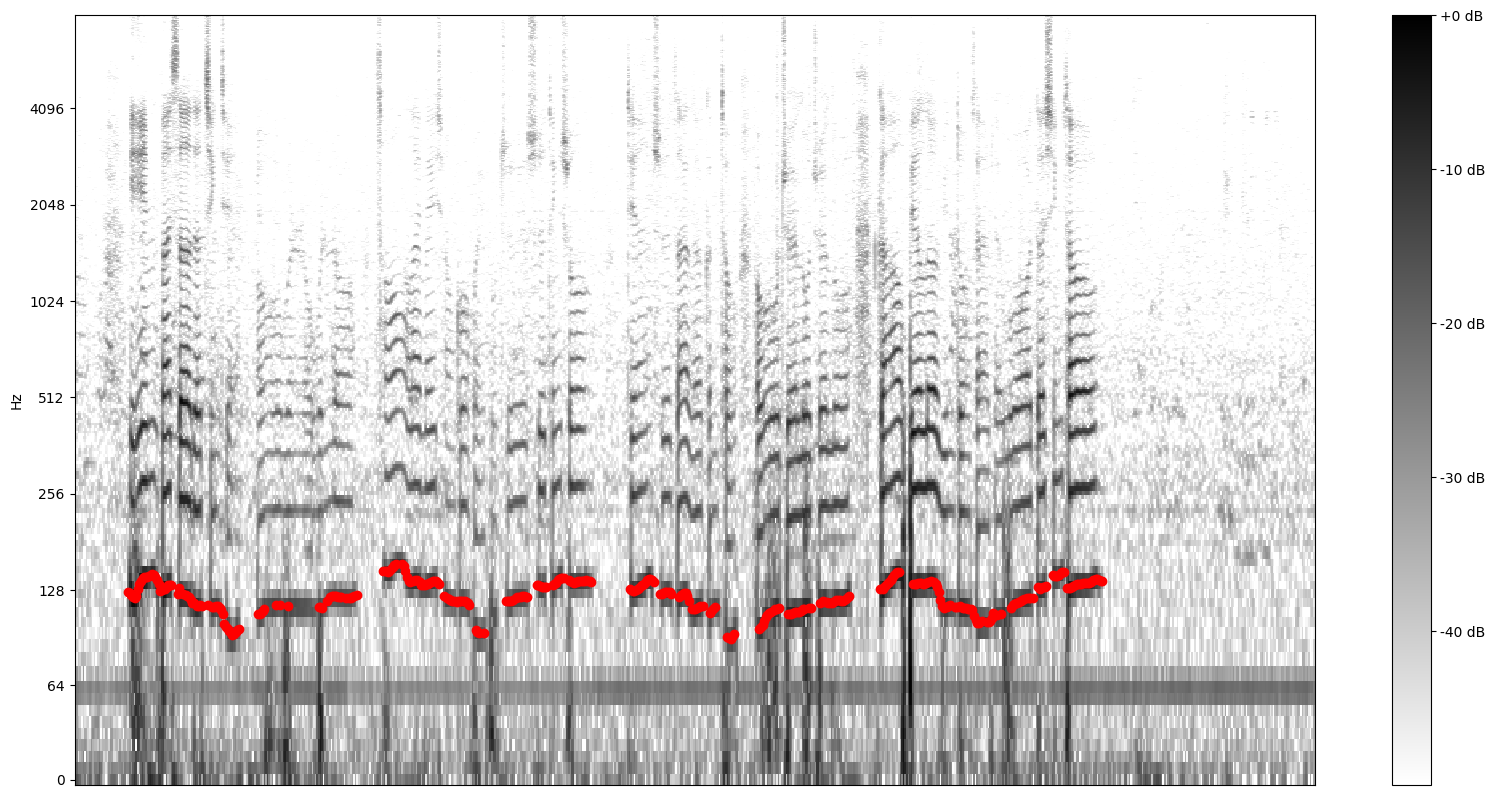

In [16]:
# plot_stft(audio_samples / MAX_ABS_INT16 , 
#           sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
# # Note: conveniently, since the plot is in log scale, the pitch outputs 
# # also get converted to the log scale automatically by matplotlib.
# plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")

# plt.show()

# Converting to pitch


This is part is challenging by itself. We have to take into account two things:
1. the rests (when there's no singing) 
2. the size of each note (offsets) 

### 1: Adding zeros to the output to indicate when there's no singing

In [17]:
# pitch_outputs_and_rests = [
#     output2hz(p) if c >= 0.9 else 0
#     for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
# ]

### 2: Adding note offsets

When a person sings freely, the melody may have an offset to the absolute pitch values that notes can represent.
Hence, to convert predictions to notes, one needs to correct for this possible offset.
This is what the following code computes.

In [4]:
def hz2offset(freq):
  A4 = 440
  C0 = A4 * pow(2, -4.75)
  # This measures the quantization error for a single note.
  if freq == 0:  # Rests always have zero error.
    return None
  # Quantized note.
  h = round(12 * math.log2(freq / C0))

  return 12 * math.log2(freq / C0) - h

### 3. Transfer frequency to pitch

In [5]:
def hz2pitch(freq, ideal_offset):
    A4 = 440
    C0 = A4 * pow(2, -4.75)
    note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    h = round(12 * math.log2(freq / C0) - ideal_offset)
    #h = round(12 * math.log2(freq / C0))
    octave = h // 12
    n = h % 12
    return note_names[n] + str(octave)

In [20]:
# pitches = [hz2pitch(p, ideal_offset) if p != 0 else 0 for p in pitch_outputs_and_rests]

In [6]:
def vocal_pitch_recognition(file_path):
    #EXPECTED_SAMPLE_RATE = 16000
    converted_audio_file = convert_audio_for_model(file_path)
    sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')
    duration = len(audio_samples)/sample_rate
    print(f'Sample rate: {sample_rate} Hz')
    print(f'Total duration: {duration:.2f}s')
    print(f'Size of the input: {len(audio_samples)}')
    MAX_ABS_INT16 = 32768.0
    audio_samples = audio_samples / float(MAX_ABS_INT16)

    model = hub.load("https://tfhub.dev/google/spice/2")
    model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

    pitch_outputs = model_output["pitch"]
    uncertainty_outputs = model_output["uncertainty"]
    confidence_outputs = 1.0 - uncertainty_outputs
    confidence_outputs = list(confidence_outputs)
    pitch_outputs = [ float(x) for x in pitch_outputs]

    pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for p, c in zip(pitch_outputs, confidence_outputs)
    ]
    offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
    ideal_offset = statistics.mean(offsets)
    pitches = [hz2pitch(p, ideal_offset) if p != 0 else 0 for p in pitch_outputs_and_rests]
    return pitches

In [7]:
uploaded_file_name = "C:/Users/user/Desktop/MIR-FINAL/music/output.wav"

In [8]:
pitches = vocal_pitch_recognition(uploaded_file_name)

Sample rate: 16000 Hz
Total duration: 24.75s
Size of the input: 396040
